# Preprocessing data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors 

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv("mobile_cleaned.csv")

In [4]:
PhoneId = df["PhoneId"]
Rating = df["Rating"]
df = df.drop("PhoneId", axis=1).drop("Rating", axis=1)

In [5]:
Rating = Rating.values

In [6]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
Rating_s = min_max_scaler.fit_transform(Rating.reshape(-1,1))
threshold = 4.1
threshold_s = min_max_scaler.transform(np.array(threshold).reshape(-1,1))
Rating_b = list(map(lambda x:0 if x<threshold_s else 1, Rating_s))

# Train-test split

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(df, Rating, stratify=Rating_b, test_size=0.25)

In [8]:
X_train_s = standard_scaler.fit_transform(X_train)
X_val_s = standard_scaler.transform(X_val)
Y_train_s = min_max_scaler.transform(Y_train.reshape(-1,1))
Y_val_s = min_max_scaler.transform(Y_val.reshape(-1,1))
Y_train_b = list(map(lambda x:0 if x<threshold_s else 1, Y_train_s))
Y_val_b = list(map(lambda x:0 if x<threshold_s else 1, Y_val_s))

In [9]:
df.describe()

,Pixel Density,Screen Size,Weight,RAM,Processor_frequency,Screen to Body Ratio (calculated),Height,Internal Memory,Capacity,Resolution,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,...,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,344.211144,5.462317,161.343109,11.120235,1.792551,72.353343,149.946394,46.369501,3191.307918,9.592375,0.211144,0.020528,0.683284,0.085044,0.002933,0.005865,0.029326,0.035191,0.580645,0.017595,0.325513,0.002933,0.005865,0.055718,0.023460,0.0,0.014663,0.002933,0.005865,0.0,0.029326,0.011730,0.017595,0.049853,0.017595,0.008798,0.008798,0.011730,0.011730,0.002933,...,0.002933,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.041056,0.008798,0.017595,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.002933,0.076246,0.061584,0.008798,0.011730,0.002933,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,0.002933,0.759531,0.152493,0.085044,0.020528,0.020528,0.958944
std,88.161129,0.742529,22.305556,61.320855,0.451598,9.357839,9.192305,46.435453,932.533527,5.953827,0.408720,0.142006,0.465879,0.279357,0.054153,0.076471,0.168965,0.184532,0.494179,0.131668,0.469255,0.054153,0.076471,0.229714,0.151583,0.0,0.120375,0.054153,0.076471,0.0,0.168965,0.107827,0.131668,0.217962,0.131668,0.093520,0.093520,0.107827,0.107827,0.054153,...,0.054153,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.198711,0.093520,0.131668,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.054153,0.265782,0.240751,0.093520,0.107827,0.054153,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.054153,0.427996,0.360026,0.279357,0.142006,0.142006,0.198711
min,143.000000,2.400000,58.000000,1.000000,1.000000,23.600000,115.600000,0.000000,1020.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000

# Perceptron class

In [10]:
class Sigmoid:
  def __init__(self):
    self.w = None
    self.b = 0

  def perceptron(self, x):
    return np.dot(self.w, x.T) + self.b
  
  def model(self, x):
    return 1/(1+np.exp(-self.perceptron(x)))
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      Y_pred.append(self.model(x))
    return np.array(Y_pred)

  def grad_w(self, x, y):
    fx = self.model(x)
    return (fx-y)*fx*(1-fx)*x

  def grad_b(self, x, y):
    fx = self.model(x)
    return (fx-y)*fx*(1-fx)

  def log_w(self, x, y):
    fx = self.model(x)
    return (fx-y)*x

  def log_b(self, x, y):
    fx = self.model(x)
    return (fx-y)
  
  def loss_mse(self, y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return (1/2)*np.power(y_pred-y_actual, 2)

  def loss_ce(self, y_pred, y_actual):
    return -((1-y_actual)*np.log(1-y_pred) + y_actual*np.log(y_pred))

  def loss(self, Y_pred, Y, loss_func="ce"):
    l = 0
    
    if loss_func=="ce":
      for fx,y in zip(Y_pred,np.array(Y)):
        l -= self.loss_ce(fx, y)
  
    else:
      for fx,y in zip(Y_pred,np.array(Y)):
        l -= self.loss_mse(fx, y)
    return l

  def fit(self, X, Y, epochs=10000, lr=0.001, display_loss=True, loss_func="ce"):
    self.w = np.zeros((1,X.shape[1]))
    self.b = 0
    loss = {}
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = np.zeros(X.shape[1])
      db = 0
      if loss_func=="ce":
        for x,y in zip(X,Y):
          dw += self.log_w(x,y)
          db += self.log_b(x,y) 
      if loss_func=="mse":
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
      self.w -= lr*dw
      self.b -= lr*db  
      
      loss[i] = -self.loss(self.predict(X), Y, loss_func=loss_func)

    if display_loss:
      self.display_loss(loss)

  def display_loss(self, loss):
    plt.plot(list(loss.values()))

# Mean square Error

In [11]:
sgn = Sigmoid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


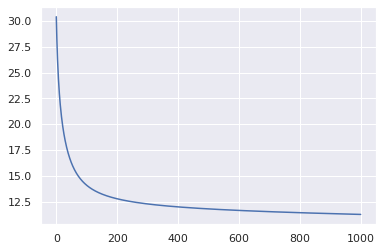

In [12]:
sgn.fit(X_train_s, Y_train_b, epochs=1000, loss_func="mse")

In [13]:
Y_pred = sgn.predict(X_val_s)
Y_pred_b = list(map(lambda x:0 if x<threshold_s else 1, Y_pred))
print(accuracy_score(Y_pred_b, Y_val_b))

0.8372093023255814


# Cross Entropy

In [14]:
sgn2 = Sigmoid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


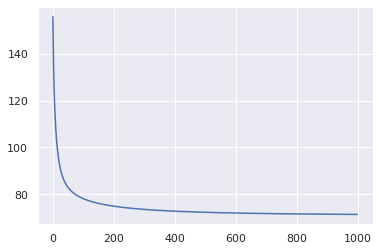

In [15]:
sgn2.fit(X_train_s, Y_train_b, epochs=1000, loss_func="ce")

In [16]:
Y_pred2 = sgn.predict(X_val_s)
Y_pred_b2 = list(map(lambda x:0 if x<threshold_s else 1, Y_pred2))
print(accuracy_score(Y_pred_b2, Y_val_b))

0.8372093023255814
